# Fastball v.s. Pitcher Performance: Is Pitching Fast a Guarantee of Success?
Fastball is arguably one of the most interesting aspects to watch in a baseball game: no intentional breaking, no change of speed, but simply putting pure challenge on batter. People often associate a fastball with its speed, and there are several reasons to it: 
1. Most professional leagues use specific instruments (e.g. radars, cameras) that can detect the speed of a ball, and can exhibit the number to the audiance right away (mostly by showing it on an giant electronic board in the ballpark). This makes the speed of pitch the most accessible piece of information.
2. Speed is one of the easiest statistics to understand and interpret, and it is somewhat relatable to everyday life (e.g. car speed)
3. Fastball usually has the fastest speed among all kind of pitches, which produces the greatest number that people can see on a ballpark's electronic board. Imagine if you are in a Major League baseball game and a pitcher throws a fastball that reaches three digit (over 100 mph), audiance will be wowing at it.  

As the understanding of kinesiology becomes more advanced these days, athletes are trained to reach beyond their limit that they can never imagine. In baseball, more pitchers are able to throw over 100 miles per hour. However, despite the awe of the speed statistics, does this really guarantee these fireball pitchers to perform well in the league? How about the other pitchers who are not able to throw that fast, are they doomed instead? Clearly, the answers are false to both questions, since a baseball game is way more complicated to be addressed with just one piece of statistics.   

But at the end of the day, why does fastball speed ever matter? This study aims to explore the topics below: 
1. Correlation between average fastball speed and walks-and-hits-per-inning-pitched (WHIP), a pitcher's performance metric.
2. Correlation between average fastball speed and K/9 (strikeouts per nine innings), a metric that measures the strikeout rate of a pitcher.
3. Interpretting the essentials of WHIP and K/9.
4. The roles for hard-throwing pitchers on a team

# Setup
The datasets for the study is from Kaggle (https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018). Although the title of this page indicates year 2015-2018, the author of the page did add datasets from year 2019 as well. The study will based on the latest dataset, which is the MLB pitch-by-pitch data in season 2019. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# read files 
raw_atbats = pd.read_csv('data/2019_atbats.csv')
raw_games = pd.read_csv('data/2019_games.csv')
raw_pitches = pd.read_csv('data/2019_pitches.csv')
raw_players = pd.read_csv('data/player_names.csv')

# Data Cleaning and Wrangling 

First, we need to make sure that all players' ids are included in `raw_players`.

In [3]:
pitcher_ids = raw_atbats['pitcher_id'].unique()
batter_ids = raw_atbats['batter_id'].unique()

for i,n in enumerate(pitcher_ids):
    assert i in raw_players['id']
        
for i,n in enumerate(batter_ids):
    assert i in raw_players['id']

# `df` - pitch-by-pitch data
Among the four datasets, the major foucs will be `raw_pitches`. This dataset records every pitch/at-bat in the 2019 MLB season, which is identified by a unique at-bat id (`'ab_id'`). However, it does not specify which pitcher/batter was involved in each at-bat. We therefore extract relevant information from `raw_atbats` (`'ab_id'`,`'pitcher_id'`,`'batter_id'`) and merge it to `raw_pitches`. On top of that, `inning` is also extracted from `raw_atbats` since it will be used later too. 

`df` will the the dataframe of pitch-by-pitch data for us to use in the later parts.

In [4]:
# extract pitcher_id, batter_id, ab_id (at bat id) and inning from raw_atbats
atbats_extract = raw_atbats[['ab_id','pitcher_id','batter_id','inning']]

# merge df_atbats_extract to df_pitches
df = pd.merge(raw_pitches, atbats_extract, how='left', on='ab_id')
df.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,pitcher_id,batter_id,inning
0,0.00,2.15,88.8,80.7,placeholder,placeholder,22.8,4.8,24.0,-8.47,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,571666,594777,1.0
1,0.34,2.31,89.9,81.8,placeholder,placeholder,22.8,3.6,24.0,-7.10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,571666,545361,1.0
2,-0.05,2.03,85.7,79.6,placeholder,placeholder,9.6,6.0,24.0,3.65,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,571666,545361,1.0
3,0.49,0.92,85.4,78.5,placeholder,placeholder,24.0,7.2,24.0,-13.77,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,571666,545361,1.0
4,-0.13,1.11,84.6,77.6,placeholder,placeholder,26.4,8.4,24.0,-15.99,...,1.0,1.0,1.0,4.0,0.0,0.0,0.0,571666,545361,1.0


### Pitch Group (Fastball, Offspeed, Breaking)

In [5]:
df['pitch_type'].unique()

array(['FF', 'SL', 'CH', 'FT', 'SI', 'KC', 'CU', 'FC', 'FS', 'EP', nan,
       'KN', 'FO'], dtype=object)

According to Statcast (https://baseballsavant.mlb.com/statcast_search), pitch types can be categorized into three major groups: fastball, offspeed and breaking. Below is the list of pitch types that falls into each class:
- Fastball: 4-seam (FF), 2-seam/sinker (SI)**, cutter (FC)
- Offspeed: changeup (CH), split-finger (FS), forkball (FO)***, screwball (SC)
- breaking: curveball (CU), knuckle curve (KC), slow curve (CS), slider (SL), sweeper (ST), slurve (SV), knuckleball (KN), eephus (EP)
  
The source of our datasets (https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018) also provides pitch type definitions. While most of the abbreviations correspond with Statcast, some are actually different. 
1. The dataset has 2-seam fastball (FT) as a seperate category from sinker. 
2. FO is pitchout in the dataset, instead of fork ball.
3. Some of the pitch types in Statcast do not exist in the dataset; instead, some of the pitches might be put into a more general term (e.g. slow curve might be identified as curveball). Despite the differences, the matter would not be significant in this study because we will not dive into the performance of each specific pitch type (instead, we will just look at fastball or breaking ball in general).
  
Combined, we will group the pitch types into the following order:
- Fastball: FF, FT, FC, SI
- Offspeed: CH, FS
- Breaking: CU, KC, SL, KN, EP
- Other: FO, nan 

In [6]:
# categorize each pitch type ('pitch_type') into one of fastball, offspeed, breaking or unknown 

def map_categorize_pitch(pitch):
    if pitch in ['FF','FT','FC','SI']:
        return 'fastball'
    elif pitch in ['CH', 'FS', 'FO']:
        return 'offspeed'
    elif pitch in ['CU', 'KC', 'SL', 'KN', 'EP']:
        return 'breaking'
    else: 
        return 'unknown'

df['pitch_group'] = df['pitch_type'].apply(map_categorize_pitch)
df[['pitch_type','pitch_group']].head()

,pitch_type,pitch_group
0,FF,fastball
1,FF,fastball
2,SL,breaking
3,CH,offspeed
4,CH,offspeed


## `players` - Pitchers Statistics 

The goal here is to summarize the statistics of each pitchers from `df`, which will be stored in a different variable called `players`. Below is a list of statistics that we will summarize for each pitcher: 
- walks
- hits
- ip
- WHIP (walks and hits per inning pitched)
- average fastball speed 
- K/9 (strikeouts per nine innings)  
  

Details and usages of these features will be introduced in later sections. 

In [7]:
# walks: count any ball event ('code' == 'B') when ball count ('b_count') is already 3 
s_walks = df[(df['code'] == 'B') & (df['b_count'] == 3)].groupby('pitcher_id').size().rename('walks')

# hits: when an event code is either 'in play, no out' ('D') or 'in play, runs' ('E')
s_hits = df[(df['code'] == 'D') | (df['code'] == 'E')].groupby('pitcher_id').size().rename('hits')

# innings pitched (ip) = (batters out)/3. 
atbats = raw_atbats.copy()
atbats['prev_o']=atbats['o'].shift(1).fillna(0) # 'o' is the total out count of that inning after the at-bat event

def get_n_out(o,prev_o):
    '''
    if a pitcher gets one more out, it should return 1. 
    if double play happens, it will return 2 (and 3 for triple play).
    '''
    if prev_o>o: 
        return o-0 # makes sure prev_o is reset to 0 at any change of inning
    else:
        return o-prev_o 

atbats['n_out']=atbats.apply(lambda row: get_n_out(row['o'], row['prev_o']), axis=1)
s_ip = atbats.groupby('pitcher_id')['n_out'].sum()/3


# create the dataframe players 
players = pd.concat([s_walks,s_hits,s_ip], axis=1, join='outer',keys=['walks','hits','ip']).fillna(0)
# Drop those who failed to get any out (because their ip = 0 and will be meaningless to calculate their WHIP.)
players = players[players['ip'] != 0] 


# WHIP = (walks+hits)/ip
def get_whip(w,h,ip):
    return (w+h)/ip

players['whip']=players.apply(lambda row: get_whip(row['walks'],row['hits'],row['ip']), axis=1)
players.head()


,walks,hits,ip,whip
pitcher_id,,,,
282332,34.0,120.0,107.333333,1.434783
407845,20.0,50.0,46.000000,1.521739
424144,7.0,43.0,40.333333,1.239669
425794,45.0,189.0,171.666667,1.363107
425844,19.0,189.0,208.666667,0.996805


### Average Fastball Speed 
As mentioned in the part "change of speed", two types of speed were measured for each pitch. To calculate the average fastball speed for each pitcher, we decided to use `start_speed` since it was not affected by the variability caused by drag on different types of pitches.

In [8]:
# average fastball speed
s_afs = df[df['pitch_group']=='fastball'].groupby('pitcher_id')['start_speed'].mean().rename('avg_fastball_speed')

# prevent ValueError produced by running this cell multiple times
try:
    players = players.join(s_afs)
except ValueError:
    pass

players.head()

,walks,hits,ip,whip,avg_fastball_speed
pitcher_id,,,,,
282332,34.0,120.0,107.333333,1.434783,88.547390
407845,20.0,50.0,46.000000,1.521739,93.802245
424144,7.0,43.0,40.333333,1.239669,91.686103
425794,45.0,189.0,171.666667,1.363107,88.018625
425844,19.0,189.0,208.666667,0.996805,89.937648


### K/9
K/9 (strikeouts per nine innings) rate measures the strikeout aspect of a pitcher (details see 2. Correlation Between Average Fastball Speed and K/9). Both the total number of strikeouts and K/9 will be calculated for each pitcher. 


In [9]:
# find all the notations that are considered strikeout
for i in atbats['event'].unique():
    if 'strike' in i or 'Strike' in i:
        print(i)

Strikeout
Strikeout Double Play


In [10]:
# total number of strikeouts 
s_k = (
    atbats[(atbats['event']=='Strikeout') | (atbats['event']=='Strikeout Double Play')]
    .groupby('pitcher_id')
    .size()
    .rename('total_k')
)
try:
    players = players.join(s_k)
except ValueError:
    pass

players['total_k'].fillna(0, inplace=True)

# K/9
players['k9'] = (players['total_k']/players['ip']) * 9
players.head()

,walks,hits,ip,whip,avg_fastball_speed,total_k,k9
pitcher_id,,,,,,,
282332,34.0,120.0,107.333333,1.434783,88.547390,107.0,8.972050
407845,20.0,50.0,46.000000,1.521739,93.802245,48.0,9.391304
424144,7.0,43.0,40.333333,1.239669,91.686103,48.0,10.710744
425794,45.0,189.0,171.666667,1.363107,88.018625,153.0,8.021359
425844,19.0,189.0,208.666667,0.996805,89.937648,187.0,8.065495


# EDA

## Pitch Speed v.s. Break Length
As mentioned in the introduction, fastballs are pitches that are fastest and have no intentional breaking. Below is the plot that shows how fastballs behave compared to the other two pitch_group (offspeed and breaking).

/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

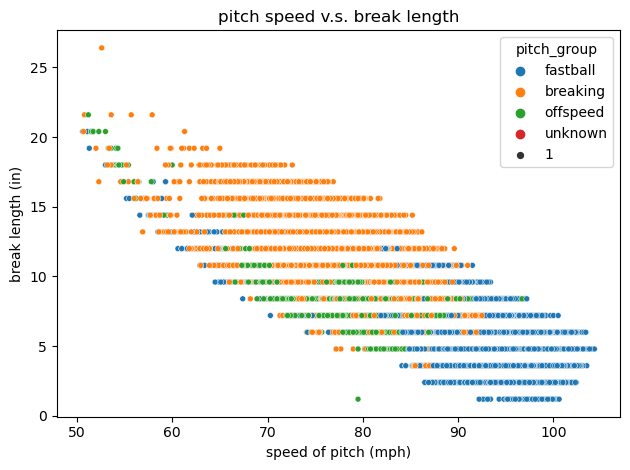

In [11]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='start_speed', y='break_length', hue='pitch_group', ax=ax, size=1)
ax.set_xlabel('speed of pitch (mph)')
ax.set_ylabel('break length (in)')
ax.set_title("pitch speed v.s. break length")

plt.tight_layout()
plt.show()

The horizontal-like distributions may be due to the scale used when measuring the break length, which only had several possible values (e.g.3.6in or 4.8in). Still, the plot shows that fastballs are the fastest and have the least break length compared to offfspeed and breaking balls.

## Distribution of Pitcher's Average Fastball Speed

In [12]:
players['avg_fastball_speed'].describe()

count    798.000000
mean      92.375123
std        3.837966
min       61.479104
25%       90.946770
50%       92.749381
75%       94.438152
max      101.127715
Name: avg_fastball_speed, dtype: float64

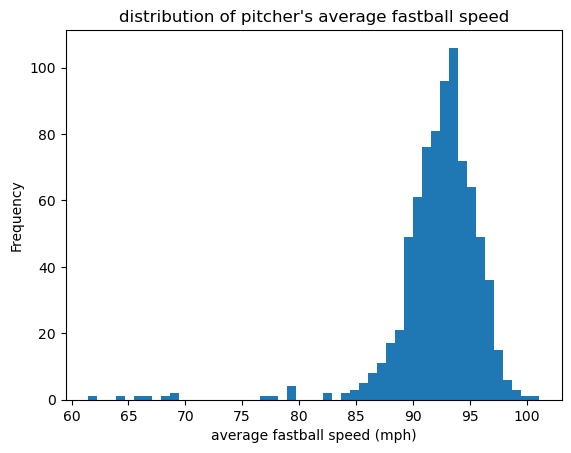

In [13]:
players['avg_fastball_speed'].plot.hist(bins=50)
plt.xlabel('average fastball speed (mph)')
plt.title("distribution of pitcher's average fastball speed")
plt.show()

The histogram along with the statistics accessed by calling `.describe()` shows that the mean of players' average fastball speed is 92.38mph, with a standard deviation of 3.84, and a median of 92.75mph. Max average fastball speed reaches 101.13mph.

# 1. Correlation Between Average Fastball Speed and WHIP 

To measure a goodness of a pitcher, there are several useful metrics including ERA (earned run average), FIP (fielding independent pitching), WHIP (walks and hits per inning pitched), and more. This study will use WHIP as the main metric, due to the following reasons:
1. The formula of WHIP is relatively simple (mlb.com). The formula is: 
\begin{align}
WHIP = \frac{Walks + Hits}{innings\;pitched}
\end{align}
which means that a pitcher with a lower WHIP tends to be better, because he allows less walks and hits in the game.
2. It targets one of the most fundamental goals of a pitcher: keeping runners off the basepaths (that is, minimize the walks and hits) (mlb.com). 
  
Note that WHIP also has its shortcomings: "hit batsmen, errors and hitters who reach via fielder's choice do not count against a pitcher's WHIP" (mlb.com). Nevertheless, WHIP would still be a good and simple starting point to measure the performacne among pitchers. 
  
Below is the plot of pitchers average fastball speed versus WHIP, with the correlation coefficient. 
Since nan values may exist in the column avg_fastball_speed (for those who did not throw any fastballs), we need to drop the rows before calculating the correlation coefficient.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


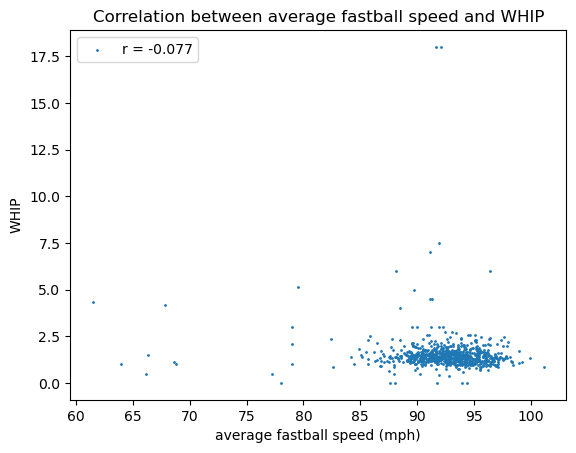

In [14]:
# only keep the rows where a pitcher did throw at least one fastball in the season
players_fb = players.dropna(subset=['avg_fastball_speed'])

# calculate the correlation coefficient
r_whip = np.corrcoef(players_fb['avg_fastball_speed'],players_fb['whip'])[0,1]

players_fb.plot.scatter(x='avg_fastball_speed', y='whip', s=1, label=f'r = {r_whip:.3f}')
plt.xlabel('average fastball speed (mph)')
plt.ylabel('WHIP')
plt.title('Correlation between average fastball speed and WHIP')
plt.show()

No clear linear relationship can be observed from the two variables. So why does fastball speed matter after all? 

# 2. Correlation Between Average Fastball Speed and K/9

Recall that in WHIP, the numerator is (walks + hits), which means that how a batter got out (e.g. strikeout, fly-out, ground-out, etc.) is not taken into calculation. Among these conditions, strikeout is the only one that does not need to depend on other defensive factors - in other words, only in the event of a strikeout, ball is never in play and no fielding error will be made, and the out is 100% contributed by the pitcher's effort.  
  
K/9 (strikeouts per nine innings) rate measures how many strikeouts a pitcher averages for every nine innings pitched (mlb.com). The formula of K/9 is:
\begin{align}
K/9 = \frac{\Sigma strikeouts}{innings}\times9
\end{align}
  
Note that it is inappropriate to measure the goodness of a pitcher based on his K/9, since strikeout is not the only way to take out a batter.

Does pitchers who have a faster average fastball speed tend to score higher in K/9? The plot below shows the correlation between avaerage fastball speed and K/9.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


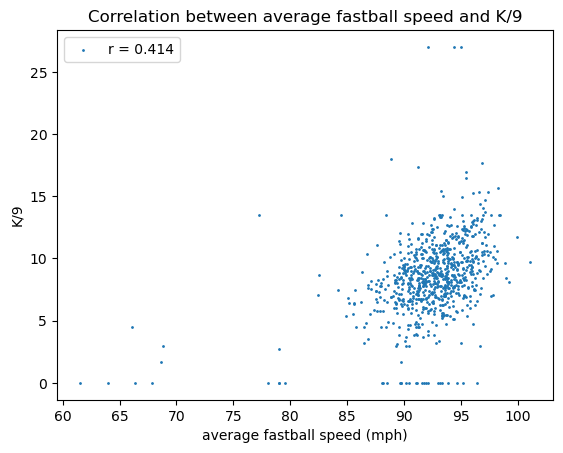

In [15]:
# calculate the correlation coefficient
r_k9 = np.corrcoef(players_fb['avg_fastball_speed'],players_fb['k9'])[0,1]

players_fb.plot.scatter(x='avg_fastball_speed', y='k9', s=1, label=f'r = {r_k9:.3f}')
plt.xlabel('average fastball speed (mph)')
plt.ylabel('K/9')
plt.title('Correlation between average fastball speed and K/9')
plt.show()

The result shows a positive linear relationship between average fastball speed and K/9. While the strength is only moderate (r=0.414), it is still a lot better than what we got from WHIP (r=-0.077).

# 3. Interpretting the Essentials of WHIP and K/9
For pitchers who had a fireball fastball in their arsenal in the MLB season 2019, the two results above suggest that: 
1. This was likely to be irrelevant to their overall WHIP, or the sum of walks and hits they made per inning. 
2. They might tend to get a higher K/9, or strikeout rate. 

Although both WHIP and K/9 are some metrics used to measure a pitcher, their concepts are different. As mentioned above, WHIP measures how much walks plus hits a pitcher may make in average (per inning), while K/9 measures how much strikeout a pitcher may make in average (per nine innings). 

Here comes the tricky part: in an atbat, only one of a strikeout or a walk/hit can happen; however, in a series of atbats (in an inning, for example), more strikeout does not necessarily mean there is less walks/hits. This is because the inning only ends when the third out is made, and before that, an unlimited amount of walks/hits can happen. An example is that even if a pitcher has a perfect number in K/9 = 27 (every out made is strikeout), it does not mean there will be no hit or walk in the game and is still possible to be scored by the opposing team. 

At the end of the day, the way of winning a baseball game is to lose less points than the opposing team, and allowing less hits or walks will lower the chance of being scored. So the goal is to minimizing the walks/hits and getting the outs as fast as possible. Again, even strikeout is an efficient way of getting rid of batters (does not need to rely on other position players), it is not the only way. For fastball-based pitchers who may tend to make more outs through strikeout, they still need to prevent the batters they face from reaching base (walk or hit). 

# 4. The Role for Hard-throwing Pitchers on a Team

It is common to see hard-throwing pitchers as closers (e.g. Aroldis Chapman). A closer is a pitcher who throws at the last inning (e.g. 9th inning) to ensure the victory of a game. One possible reason of hard-throwing pitchers being closers is that when a pitcher is designated to throw only one inning, he can maximize the intensity of throwing in this exact inning, without considering the potential fatigue induced by extended pitching cycle. 

Below is a plot that shows the spread of fastball speed of each inning. We would expect to see more fastballs with higher speed appear in the 9th inning, which is typically the last inning of a game. 

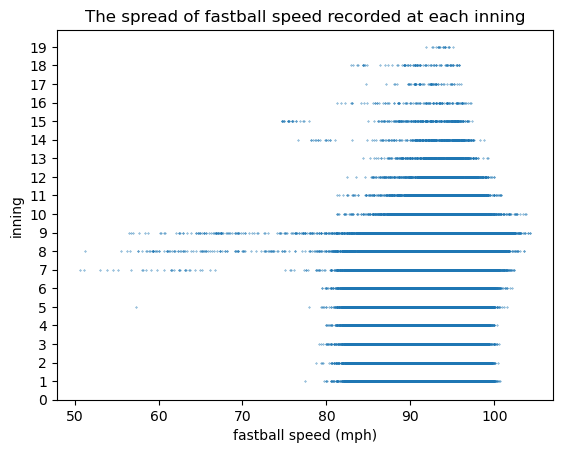

In [16]:
df_fb = df[df['pitch_group']=='fastball']
max_inning_n = df['inning'].max()
# df_fb.head()

df_fb.plot.scatter(x='start_speed',y='inning', s=0.1)
plt.yticks(np.arange(0,max_inning_n+1,1))
plt.xlabel('fastball speed (mph)')
plt.ylabel('inning')
plt.title('The spread of fastball speed recorded at each inning')
plt.show()

Those fastest fastballs did appear in the 9th inning. Other relatively fast fastballs were also recorded close to the end of a game (inning 8, 9 or 10), as the graph shows a little 'spike' around there.

# 5. Conclusion
In this study, we discussed why the speed of a fastball, or the average fastball speed of a pitcher matters in the MLB. A faster average fastball speed does not guarantee an MLB pitcher to perform well in terms of WHIP, whereas it is related to higher strikeout rate (K/9) to some extent. Although a great fastball pitcher may make more strikeouts, this does not guarantee him from being hit less or making less walks, and preventing batters from reaching base is still one of the primary tasks. Finally, one of the common roles for a hard-throwing fastball pitcher is closer, for which they only need to focus on pitching in the last inning(s) with full intensity. This aligns with the plot which shows that the fastest pitches appears in the 9th inning or the last few innings of games. 

The study is based on the overall data of a season, instead of at an individual or pitch-by-pitch level. It is important to recognize the fact that baseball is an extremely intricated sport which contains all kinds of conditions, and under different condition a different approach may be used. For example, the statistics of a certain batter, left-handed/right-handed of a pitcher or a batter, pitch count, pitch sequence, etc. All kinds of factors can affect the decision made and the subsequent result. Therefore, a bigger and complicated model is required to make a better prediction and decision on a pitch-by-pitch basis.

# 6. The Next Steps

As mentioned in part 4., hard-throwing pitchers are commonly seen in the last few innings. But if applying the knowledge from part 3, it actually makes an interesting idea. Theoretically, from a team manager's perspective, having hard-throwing pitchers on the roster can be a good thing. When a pitcher does not need to rely too much on defense, the team actually has greater freedom to sign sluggers, and for these sluggers, it will still be acceptible when their defense is less optimal. The precondition of this would be the pitcher being able to pitch consistently across multiple innings (e.g. starting pitchers or long relievers). This strategy may be more useful for those franchises with smaller markets and having difficulties to sign multiple all-star level players. 

However, the test of this part would require the salary cap data of each team, and possibly need data across multiple seasons. If the data is available, it would be an interesting topic to be discussed.

Next, one of the weaknesses of this study is that the original dataset does not include information about spin rate of a pitch (all valeus are either 'placeholder' or nan).

In [17]:
df['spin_rate'].unique()

array(['placeholder', nan], dtype=object)

This makes the classification of pitchers into two groups, whether he is a fastball-based pitcher or not, being difficult, as spin rate is another crucial part of a high-quality fastball. If spin rate is available, a possible approach of classifying pitchers into the two groups would be: 
1. Similar to the dataframe `players` in this study, summerize the following data of each pitcher and store it in the dataframe. 
    - average fastball speed 
    - average fastball spin rate 
    - ratio of fastball used over all pitches (including offspeed and breaking balls)
    - the batters performance against fastball 
    - (etc.) *may need to use techniques such as feature importance, feature selection, feature engineering, and domain-specific knowledge in order to create a plausible model
2. Use unsupervised machine learning methods to cluster them into two groups. (for example, if using K-Means algorithm, set `n_clusters = 2`). Note that if using a distance-based model like K-Means, the data should be scaled (for example, z-score) to ensure the validity of measurement. Select an ideal model, and then train and evaluate the model. 
3. With the result, investigate the top performers (e.g. low WHIP score with innings-pitched over a certain threshold) in each group. Identify the strengths and weaknessess of each type of pitchers.  

While the scheme is preliminary and would require trials and errors to refine, the expected results would provide some insights for coaches, trainers and pitchers such that they can tailor the pitching strategy to an individual by referring to this data-driven big picture. 

# 7. Clustering of Pitchers 
Since `spin_rate` is not presented in the dataset, we skip this feature for now. However, it is worth noting that spin rate is a crucial part of fastball quality, and should be taken into consideration whenever possible. 

## feature selection and engineering 

In [20]:
# first we will start simple: only having afs and fb_ratio as features)
pitchers = players[['avg_fastball_speed']].copy() # afs

pitchers

,avg_fastball_speed
pitcher_id,
282332,88.547390
407845,93.802245
424144,91.686103
425794,88.018625
425844,89.937648
...,...
576397,NaN
592407,93.900000
607223,88.033333


In [ ]:
# preprocessing 

In [ ]:
# clustering 

In [21]:
# archive 
# cols: afs, fb_ratio, os_ratio, bb_ratio, whiff (S/(S+F+Q+R+X+D+E))
# fb_k_ratio, fb_hit_ratio

# 8. ...TBD
Here we analyze another dataset from Statcast(https://baseballsavant.mlb.com/). 
The dataset contains selected pitcher statistics in from year 2016 to 2023, due to the reason that this dataset includes Statcast Stats, which are only available after season 2015. Features include the following statistics of fastball, offspeed and breaking ball:
- use percentage (_formatted)
- average speed
- average spin
- average horizontal break (x)
- average vertical break (z)
- average break 
- speed range

In the following analysis, we will explore the relationship between fastball & offspeed versus 'swing and a miss' rate (whiff%). As discussed in part 3, we see fastball speed is somewhat related to strike out rate. In this part, we are curious that will a good quality fastball accompanied by a 'right' offspeed pitch gives the pitcher an edge, such that the batter finds harder to contact the ball. 

In [65]:
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer
)
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split
)
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [80]:
statcast = pd.read_csv('data/stats.csv')
print(statcast.shape)
statcast.head()


(878, 30)


,"last_name, first_name",player_id,year,p_game,p_formatted_ip,k_percent,p_era,whiff_percent,n_fastball_formatted,fastball_avg_speed,...,breaking_avg_break,breaking_range_speed,n_offspeed_formatted,offspeed_avg_speed,offspeed_avg_spin,offspeed_avg_break_x,offspeed_avg_break_z,offspeed_avg_break,offspeed_range_speed,Unnamed: 29
0,"Colon, Bartolo",112526,2016,34,191.2,16.2,3.43,13.4,89.4,88.4,...,7.9,1.9,4.3,81.4,1683.0,-13.2,-32.0,16.2,1.5,NaN
1,"Sabathia, CC",282332,2016,30,179.2,19.8,3.91,22.9,71.4,89.3,...,11.7,1.9,5.7,82.5,1957.0,11.4,-27.3,14.6,1.5,NaN
2,"Dickey, R.A.",285079,2016,30,169.2,17.3,4.46,23.6,13.0,82.9,...,9.8,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Lackey, John",407793,2016,29,188.1,24.1,3.35,25.2,80.9,90.0,...,12.0,2.0,5.5,84.9,1871.0,-14.5,-27.5,16.6,1.8,NaN
4,"De La Rosa, Jorge",407822,2016,27,134.0,17.6,5.51,24.4,55.4,89.3,...,12.8,3.8,34.3,82.2,1330.0,12.3,-35.9,13.0,1.4,NaN


In [106]:
# show that pitchers included in the dataset are pitchers who pitched over a certain amount of games/innings 
# (instead of having too little appearance on the mound)
print(statcast['p_game'].min())
print(statcast['p_formatted_ip'].min())

8
41.2


## 8.1 focusing on the effects from fastball and offspeed for whiff%

In [107]:
# X = statcast.drop(columns=["p_era"])
# y = statcast["p_era"]
X = statcast.filter(regex='(fastball|offspeed)', axis=1)
y = statcast["whiff_percent"]
print(X.shape)
X.head()

(878, 14)


,n_fastball_formatted,fastball_avg_speed,fastball_avg_spin,fastball_avg_break_x,fastball_avg_break_z,fastball_avg_break,fastball_range_speed,n_offspeed_formatted,offspeed_avg_speed,offspeed_avg_spin,offspeed_avg_break_x,offspeed_avg_break_z,offspeed_avg_break,offspeed_range_speed
0,89.4,88.4,2148,-12.8,-23.9,17.4,2.3,4.3,81.4,1683.0,-13.2,-32.0,16.2,1.5
1,71.4,89.3,2104,7.7,-20.2,14.3,3.0,5.7,82.5,1957.0,11.4,-27.3,14.6,1.5
2,13.0,82.9,1889,-13.7,-30.0,17.4,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80.9,90.0,2244,-4.3,-23.2,13.7,4.6,5.5,84.9,1871.0,-14.5,-27.5,16.6,1.8
4,55.4,89.3,1897,10.0,-22.4,14.7,2.4,34.3,82.2,1330.0,12.3,-35.9,13.0,1.4


In [108]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Start simple: only using speed and spin of fastball & offspeed 

In [109]:
num_feats = ['fastball_avg_speed','fastball_avg_spin','offspeed_avg_speed','offspeed_avg_spin']
drop_feats = [item for item in X.columns.tolist() if item not in num_feats]

num_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessor = make_column_transformer(
    ("drop", drop_feats),
    (num_transformer, num_feats)
)

ridge = Ridge()
pipe = make_pipeline(preprocessor, ridge)

In [110]:
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,fit_time,score_time,test_score,train_score
0,0.023203,0.002211,0.258131,0.297732
1,0.004290,0.001358,0.297885,0.288902
2,0.004113,0.001440,0.335748,0.277311
3,0.003446,0.001203,0.245318,0.299190
4,0.003114,0.001308,0.263529,0.295574


### Feature Engineering 
In our experience of watching baseball, we often see that a changeup (one major type of an offspeed pitch) becomes effective when a pitcher has a really good fastball. We may hypothesize that by creating a greater difference between fastball speed or spin versus that of offspeed, the effectiveness of getting a higher whiff rate may increase.  

The following cell creates two more features: speed_diff and spin_diff, corresponding to the difference between fastball speed (or spin) and offspeed speed (or spin). 

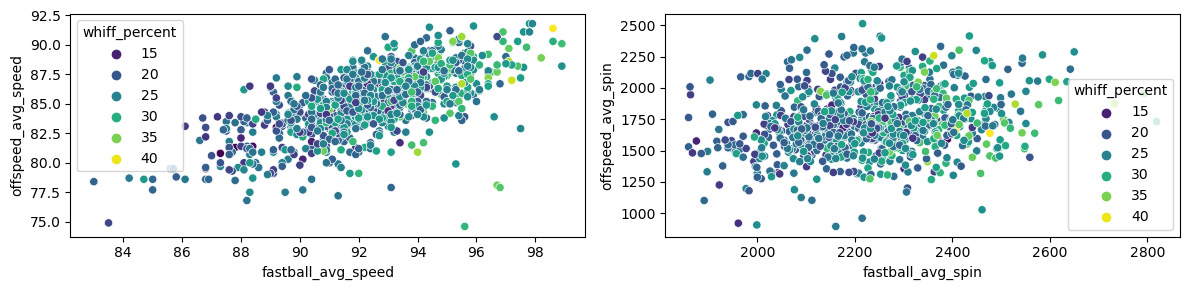

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
sns.scatterplot(data=statcast, x='fastball_avg_speed', y='offspeed_avg_speed', hue='whiff_percent', palette='viridis', ax=ax1)
sns.scatterplot(data=statcast, x='fastball_avg_spin', y='offspeed_avg_spin', hue='whiff_percent', palette='viridis', ax=ax2)
plt.tight_layout()
plt.show()

In [111]:
X_train['speed_diff'] = X_train['fastball_avg_speed'] - X_train['offspeed_avg_speed']
X_train['spin_diff'] = X_train['fastball_avg_spin'] - X_train['offspeed_avg_spin']
X_train.shape

(702, 16)

In [118]:
num_feats = ['fastball_avg_speed','fastball_avg_spin','offspeed_avg_speed','offspeed_avg_spin','speed_diff','spin_diff']
drop_feats = [item for item in X.columns.tolist() if item not in num_feats]

num_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessor = make_column_transformer(
    ("drop", drop_feats),
    (num_transformer, num_feats)
)

ridge = Ridge()
pipe = make_pipeline(preprocessor, ridge)

In [117]:
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,fit_time,score_time,test_score,train_score
0,0.007693,0.002336,0.244361,0.317659
1,0.004392,0.001617,0.313543,0.303960
2,0.003987,0.001492,0.364398,0.288196
3,0.003888,0.001567,0.230754,0.320598
4,0.003720,0.001910,0.293271,0.307532


---

In [89]:
# drop_feats = statcast.columns.tolist()[0:3] # ['last_name, first_name', 'player_id', 'year']
# num_feats = statcast.columns.tolist()[4:-1]
# preprocessor = make_column_transformer(
#     ("drop", drop_feats),
#     (numeric_transformer, num_feats)
# )

preprocessor = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ridge = Ridge()
pipe = make_pipeline(preprocessor, ridge)

In [90]:
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,fit_time,score_time,test_score,train_score
0,0.071735,0.002568,0.435441,0.441482
1,0.003050,0.000945,0.362498,0.457400
2,0.002906,0.000946,0.435843,0.440599
3,0.003749,0.000964,0.417442,0.443899
4,0.003021,0.000840,0.422655,0.442340
